# Libraries 

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generating Data with 5 Classes

In [16]:
def generate_data(samples_per_class=180):
    np.random.seed(56)
    class1 = np.random.randn(samples_per_class, 2) + np.array([2, 2])
    class2 = np.random.randn(samples_per_class, 2) + np.array([6, 6])
    class3 = np.random.randn(samples_per_class, 2) + np.array([10, 2])
    class4 = np.random.randn(samples_per_class, 2) + np.array([2, 8])
    class5 = np.random.randn(samples_per_class, 2) + np.array([10, 8])

    X = np.vstack([class1, class2, class3, class4, class5])
    y = np.array([0]*samples_per_class + [1]*samples_per_class + [2]*samples_per_class +
                 [3]*samples_per_class + [4]*samples_per_class)
    return X, y

X, y = generate_data()

# Visualizing the Data 

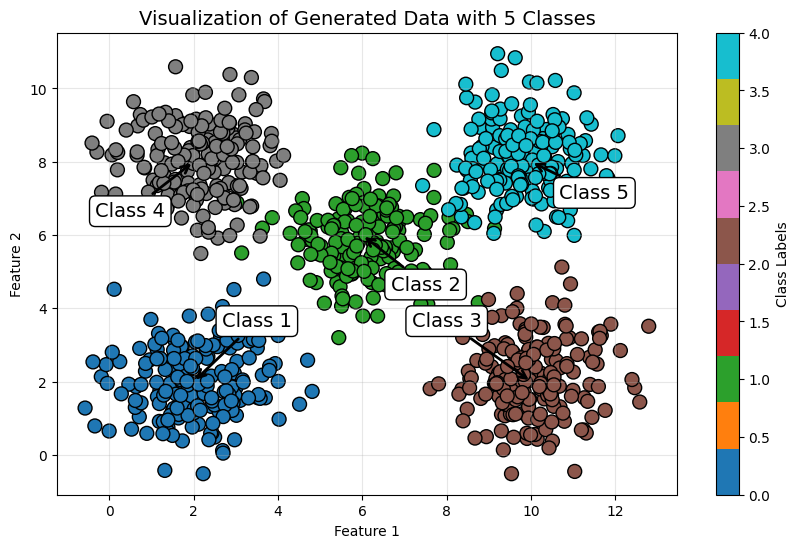

In [17]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=100, edgecolor="k")

centers = [(2, 2), (6, 6), (10, 2), (2, 8), (10, 8)]
offsets = [(1.5, 1.5), (1.5, -1.5), (-2, 1.5), (-1.5, -1.5), (1.5, -1)]

for i, (center, offset) in enumerate(zip(centers, offsets)):
    plt.annotate(f'Class {i + 1}',
                 xy=center,
                 xytext=(center[0] + offset[0], center[1] + offset[1]),
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=2),
                 fontsize=14,
                 ha="center",
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.title("Visualization of Generated Data with 5 Classes", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(alpha=0.3)
plt.colorbar(scatter, label="Class Labels")
plt.show()

# Encoding the Labels 

In [18]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Spliting the Data 

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=56)

# Creating the Neural Networks 

In [20]:
class NeuralNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr):
        self.W1 = np.random.randn(input_size, hidden_size1)
        self.W2 = np.random.randn(hidden_size1, hidden_size2)
        self.W3 = np.random.randn(hidden_size2, hidden_size3)
        self.W4 = np.random.randn(hidden_size3, output_size)
        self.lr = lr

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feed_forward(self, x):
        self.hidden_input1 = np.dot(x, self.W1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        self.hidden_input2 = np.dot(self.hidden_output1, self.W2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        self.hidden_input3 = np.dot(self.hidden_output2, self.W3)
        self.hidden_output3 = self.sigmoid(self.hidden_input3)

        self.output_input = np.dot(self.hidden_output3, self.W4)
        self.output = self.softmax(self.output_input)
        return self.output

    def backprop(self, x, y, output):
        output_delta = output - y 

        hidden_error3 = np.dot(output_delta, self.W4.T)
        hidden_delta3 = hidden_error3 * self.sigmoid(self.hidden_output3, derivative=True)

        hidden_error2 = np.dot(hidden_delta3, self.W3.T)
        hidden_delta2 = hidden_error2 * self.sigmoid(self.hidden_output2, derivative=True)

        hidden_error1 = np.dot(hidden_delta2, self.W2.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, derivative=True)

        self.W4 -= np.dot(self.hidden_output3.T, output_delta) * self.lr
        self.W3 -= np.dot(self.hidden_output2.T, hidden_delta3) * self.lr
        self.W2 -= np.dot(self.hidden_output1.T, hidden_delta2) * self.lr
        self.W1 -= np.dot(x.T, hidden_delta1) * self.lr

    def train(self, x, y):
        output = self.feed_forward(x)
        self.backprop(x, y, output)

# Training the Model

In [21]:
input_size = X_train.shape[1]
hidden_size1 = hidden_size2 = hidden_size3 = 22
output_size = y_train.shape[1]
lr = 0.0015
epochs = 1500

nn = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    nn.train(X_train, y_train)
    train_output = nn.feed_forward(X_train)
    val_output = nn.feed_forward(X_val)

    train_loss = -np.mean(np.sum(y_train * np.log(train_output + 1e-9), axis=1))
    val_loss = -np.mean(np.sum(y_val * np.log(val_output + 1e-9), axis=1))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
    val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_output, axis=1))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_accuracy*100:.2f}%, Val Acc={val_accuracy*100:.2f}%")

Epoch 0: Train Loss=3.9958, Val Loss=3.8644, Train Acc=20.74%, Val Acc=18.89%
Epoch 100: Train Loss=0.4016, Val Loss=0.4410, Train Acc=80.93%, Val Acc=76.67%
Epoch 200: Train Loss=0.3248, Val Loss=0.3893, Train Acc=83.70%, Val Acc=78.33%
Epoch 300: Train Loss=0.3195, Val Loss=0.4005, Train Acc=84.26%, Val Acc=78.33%
Epoch 400: Train Loss=0.2320, Val Loss=0.3059, Train Acc=87.41%, Val Acc=82.22%
Epoch 500: Train Loss=0.3549, Val Loss=0.4283, Train Acc=82.41%, Val Acc=77.78%
Epoch 600: Train Loss=0.3165, Val Loss=0.4016, Train Acc=83.52%, Val Acc=78.33%
Epoch 700: Train Loss=1.1885, Val Loss=1.2445, Train Acc=62.96%, Val Acc=59.44%
Epoch 800: Train Loss=0.3729, Val Loss=0.3963, Train Acc=91.85%, Val Acc=86.67%
Epoch 900: Train Loss=0.6652, Val Loss=0.6826, Train Acc=56.11%, Val Acc=54.44%
Epoch 1000: Train Loss=0.4199, Val Loss=0.4434, Train Acc=84.07%, Val Acc=81.67%
Epoch 1100: Train Loss=0.6325, Val Loss=0.6074, Train Acc=72.59%, Val Acc=68.33%
Epoch 1200: Train Loss=1.3799, Val Loss=

# Plotting the Loss & Accuracy

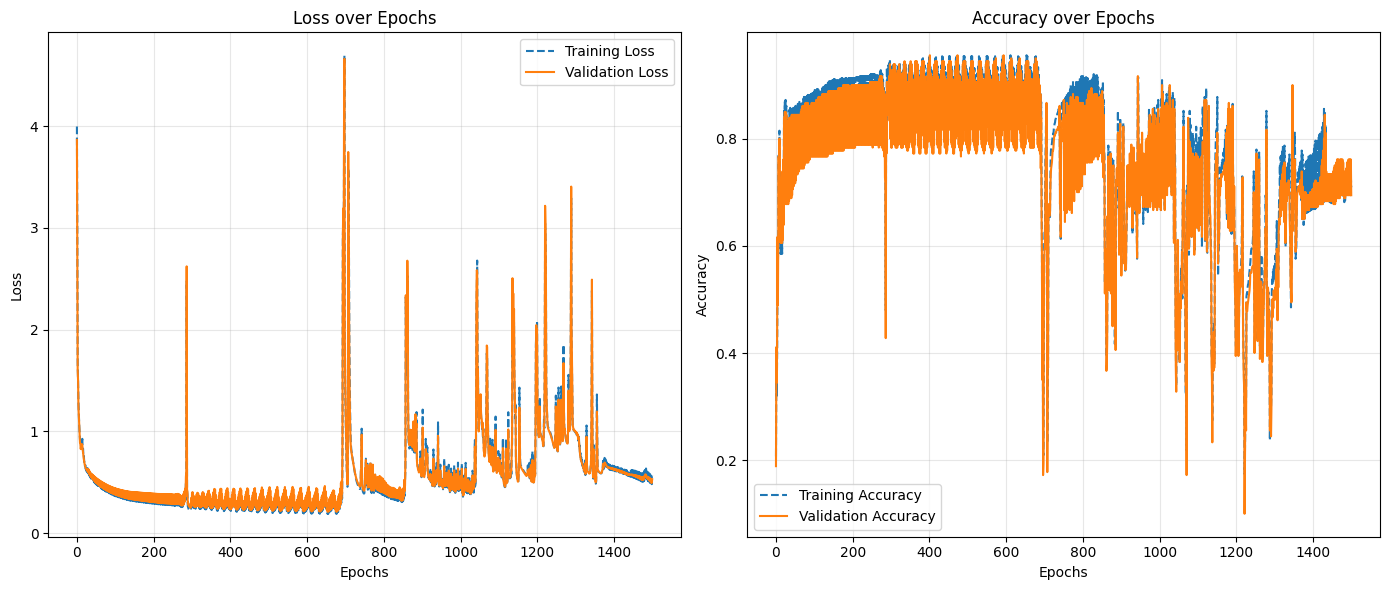

In [22]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", linestyle='--')
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", linestyle='--')
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Accuracy of TEST 

In [23]:
test_output = nn.feed_forward(X_test)
predicted_classes = np.argmax(test_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)
test_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 68.33%


# Visualization of the Predictions 

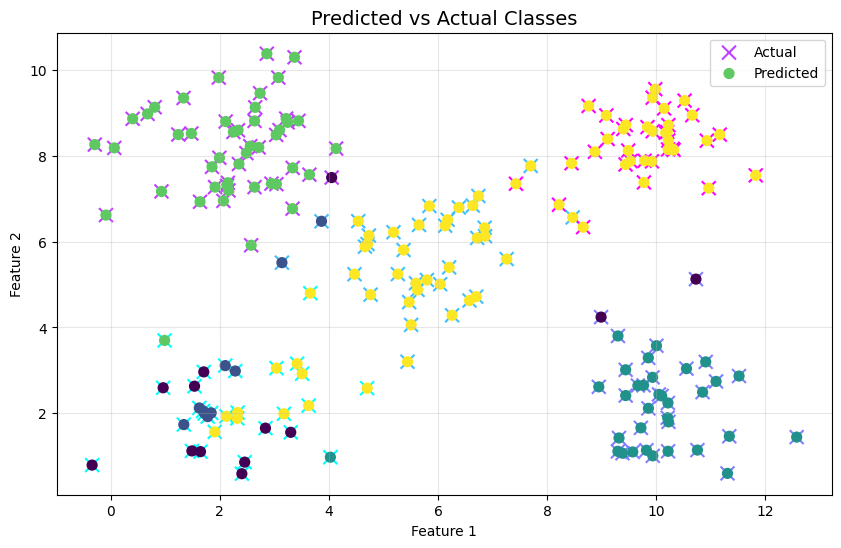

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', label='Actual')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='viridis', s=50, marker='o', label='Predicted')
plt.title("Predicted vs Actual Classes", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# The Decision Boundary 

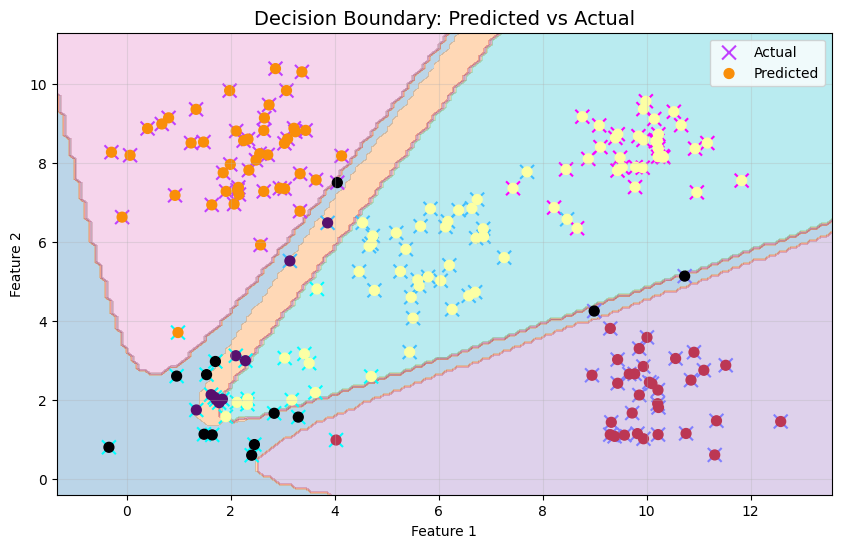

In [25]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = np.argmax(nn.feed_forward(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', label='Actual')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='inferno', s=50, marker='o', label='Predicted')
plt.title("Decision Boundary: Predicted vs Actual", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# The Classification Report 

In [26]:
y_true = actual_classes
y_pred = predicted_classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(5)]))


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.32      0.45        31
     Class 1       0.20      0.06      0.09        35
     Class 2       0.97      0.94      0.96        34
     Class 3       0.98      0.98      0.98        46
     Class 4       0.44      1.00      0.61        34

    accuracy                           0.68       180
   macro avg       0.67      0.66      0.62       180
weighted avg       0.69      0.68      0.64       180



# Visualizing the Confusion Matrix 

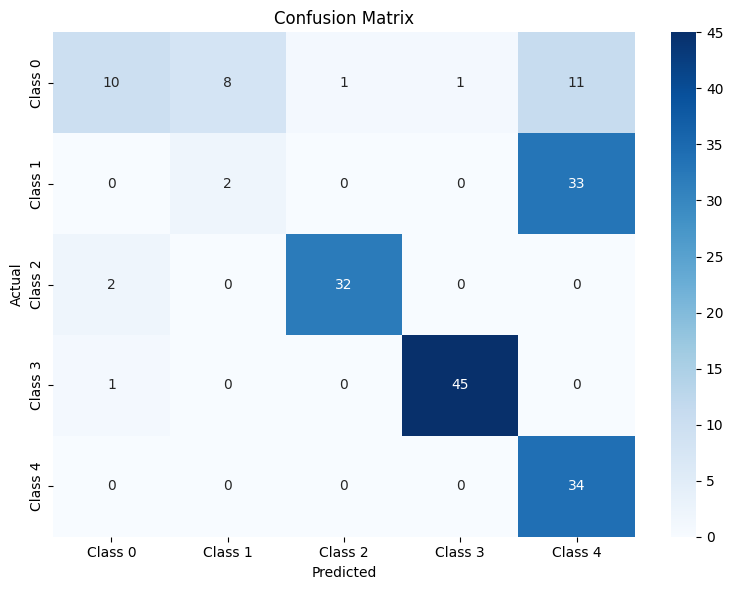

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, cmap="Blues", fmt="d",
            xticklabels=[f"Class {i}" for i in range(5)],
            yticklabels=[f"Class {i}" for i in range(5)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Conclusion 

Justification for the modification: Multi-class classification was achieved by modifying the algorithm to create synthetic data with five unique classes employing make_classification. Following the application of OneHotEncoder to one-hot encode the class labels, the network can produce a probability distribution that covers all classes. The architecture of the neural network consisted of three hidden layers utilizing ReLU activation to introduce non-linearity, concluded with an output layer featuring five neurons and softmax activation to guarantee class probabilities. Given that multi-class classification challenges are generally well-suited for the categorical cross-entropy loss function. During the prediction phase, the class with the highest probability was selected. The model was assessed using accuracy, a confusion matrix, and a classification report that included precision, recall, and F1-scores. Important Discoveries In conclusion, the results indicated that the model effectively learned to categorize inputs into the correct classes, achieving a commendable level of accuracy and relatively balanced performance among the classes. The confusion matrix and classification metrics revealed that the model performed well for most classes, despite some misclassifications likely stemming from feature overlap or minor class imbalances within the synthetic dataset. Challenges and Learned Information: Throughout the implementation, several obstacles emerged. Choosing suitable weight initialization methods and learning rates proved crucial since poor selections could hinder convergence. Frequently, debugging matrix dimensions during the forward and backward passes was a concern, particularly regarding the derivatives of softmax and cross-entropy. The need for regularization, even in synthetic contexts, was underscored by the risk of overfitting. Potential Development or Further Research Projects: Several advancements could be explored to improve performance. The incorporation of dropout or L2 regularization might help mitigate overfitting, while experimenting with more advanced optimizers such as Adam or RMSprop may enhance convergence. Visualizing training curves, testing the model on real-world datasets, and performing hyperparameter tuning could also provide deeper insights and increase robustness. Overall, the project offered valuable experience in building and refining a neural network for multi-class classification, along with a thorough analysis of implementation techniques and avenues for future research.